# Image Classification Performed Using Conventional Machine Learning Algorithms #

In this document, the performance of conventional classification algorithms (KNN, Logistic Regression, SVM, Decission Trees and Random Forest) is tested for a image classification problem. The images to classify belongs to 4 different documents: laboral contracts, Spanish ID cards, invoices and payrolls.

In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import PIL
from PIL import Image
import os
import base64
# from StringIO import StringIO
from io import StringIO
from bs4 import BeautifulSoup
import requests
import re
#import urllib2
from sklearn.decomposition import RandomizedPCA, PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm, neighbors, linear_model, tree
from bs4 import BeautifulSoup
#import cookielib
import json
from sklearn.metrics import adjusted_rand_score, accuracy_score
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.validation import check_array
from itertools import chain
from sklearn.neural_network import MLPClassifier
import seaborn
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

## 1. Helper functions ##

In this section, we define some helper functions we will use in the rest of the document.

In [3]:
image_path = '/home/raul/GIT/tfm/Notebooks/conventional_algorithms/images/'
def get_label(curr_path, label_list):
    """
    Given a name of a file (curr_path), a specific label is returned. The
    possible labels are specified in a list (label_list), and that label
    which is included in the name of the file is returned
    """
    label = None
    for curr_label in label_list:
        if curr_label in curr_path.split("/")[-1]:
            label = curr_label  
    return label

def get_extension(curr_path):
    """
    Returns the extension of a file whose full path is specified in
    the input "curr_path"
    """
    extension = curr_path.split(".")[-1]
    extension = "." + extension
    return extension
            
def rename_files(files_dir, num_range, label_list):
    """
    Rename all the files located in a directory specified by the input
    "files_dir". The following pattern is considered for the initial files:
        *) <path_including_label>_<num>.<extension>
    The <path_including_label> chunk should include a label included in 
    the "label_list", which is an input of the function which contains
    all the labels considered. The initial <num> is changed for a random
    number whose limits are set by the "num_range" input. The <extension>
    is kept.
    """
    files = os.listdir(files_dir)
    for curr_file in files:
        curr_label = get_label(curr_file, label_list)
        curr_ext = get_extension(curr_file)
        new_num = random.randint(num_range[0], num_range[1])
        new_name = curr_label + "_" + str(new_num) + curr_ext
        curr_file = files_dir + curr_file
        new_name = files_dir + new_name
        os.rename(curr_file, new_name)
        


## 2. Importing the data Data ##

Now, we will continue with the process in order to train some image clasiffiers. Our proposal is based on the [Content-based image classification in Python post](http://blog.yhat.com/posts/image-classification-in-Python.html). The first point to address is to transform the initial images in different formats (`.jpg`, `.png`, etc.) into numerical data that can be understood by the different ML algorithms. In order to do so, we will use primarly the functions `img_to_matrix` and `flatten_image` described below.

### 2.1 Helper functions for image transformation ###

Here we specify some functions focused on the data loading process

In [4]:
#setup a standard image size; this will distort some images but will get everything into the same shape
STANDARD_SIZE = (32, 32)

def img_to_matrix(filename, verbose=False):
    """
    Takes an image, defined by the input "filename" and turns it into 
    a numpy array of RGB pixels
    """
    img = PIL.Image.open(filename)
    if verbose==True:
        print("changing size from %s to %s" % (str(img.size), str(STANDARD_SIZE)))
    img = img.resize(STANDARD_SIZE)
    img = list(img.getdata())
    img = list(chain.from_iterable(img))
    img = np.array(img)
    return img

def flatten_image(img):
    """
    Takes in an (m, n) numpy array and flattens it 
    into an array of shape (1, m * n)
    """
    s = img.shape[0] * img.shape[1]
    img_wide = img.reshape(1, s)
    return img_wide[0]

def filter_images(location, extension):
    """
    Filters all the files located in a specific location deleting all 
    of them which don't have the specified location
    """
    for file in os.listdir(location):
        if not file.endswith(extension):
            full_path = location + file
            os.remove(full_path)


### 2.2 Data inport and transformation ###

In this section, we will import all the images performing the corresponding numerical transformation (RGB pixels). In order to to so, first the location of the images must be provided (`img_dir`). In addition, the possible *labels* (function `get_images`, Section I) has to be specified (`names`). As a result of these operations, the initial data will be saved in two variables: `data`, which is the numeric representation of the images, and `labels`, which stores all the labels of the imported images.

In [5]:
def get_data_labels(img_dir, names):
    """
    Given the location of a set of images (img_dir) and the 
    possible labels that they may have (names), two different
    outputs are provided:
        *) data: numerical representation (RGB indexes) of the images
        *) labels: labels of the images analysed
    """
    images = [img_dir + f for f in os.listdir(img_dir)]
    labels = []
    data = []
    counter = 0
    for image in images:
#         img = img_to_matrix(image)
#         img = list(img)
        try:
            img = img_to_matrix(image)
            img = list(img)
            #img = flatten_image(img)
            if len(img) == STANDARD_SIZE[0] * STANDARD_SIZE[1] * 3:
                data.append(img)
                if counter%100 == 0:
                    print("Image number ", counter, " loaded")
                labels.append(get_label(image, names)) 
        except:
            print(image + " couldn't be transformed")
            
        counter += 1
            
    data = np.asarray(data)
    return data, labels

names = ["dni", "nomina", "factura", "contrato"]
img_dir = "/home/raul/ini_images/"
data, labels = get_data_labels(img_dir , names)

Image number  0  loaded
Image number  100  loaded
Image number  200  loaded
Image number  300  loaded
Image number  400  loaded
Image number  500  loaded
Image number  600  loaded
Image number  700  loaded
Image number  800  loaded
Image number  900  loaded
Image number  1000  loaded


/home/raul/anaconda3/envs/deep_learning/lib/python3.6/site-packages/PIL/Image.py:2371: DecompressionBombWarning: Image size (126494020 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Image number  1100  loaded
Image number  1200  loaded
Image number  1300  loaded


/home/raul/anaconda3/envs/deep_learning/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:709: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Image number  1400  loaded
Image number  1500  loaded
Image number  1600  loaded
Image number  1700  loaded
Image number  1800  loaded
Image number  1900  loaded
Image number  2000  loaded
Image number  2100  loaded
Image number  2200  loaded


We check that everything is working fine.

In [6]:
print(len(data), len(labels))

2209 2209


In [7]:
print(data.shape)

(2209, 3072)


## 3. Training process ##

In this section, we will investigate the performance of different ML models: KNN, Logistic Regression, Decission Trees, Random Forest and SVM.

### 3.1 Define a training and test set ###

The first thing to to is to divide our data into train and test, which will be used in this section and the followings.

In [8]:
def labels_to_numeric(labels, dict_data):
    """
    A list of initial labels is transformed according to the keys 
    and values specified in the dict_data input
    """
    num_labels = [dict_data[curr_label] for curr_label in labels]
    return np.asarray(num_labels)


def get_test_train(data, names, labels, dict_data, per_training = 0.7):
    """
    Given a specific dataset where the explicative variables are 
    stored in the variable "data" and the corresponding response variables
    in the variable "names", returns the corresponding train and test
    data. By default, the ratio of training data ("per_training") is
    set to 0.7
    """
    is_train = np.random.uniform(0, 1, len(data)) <= per_training
#     y = np.where(np.array(labels)==names[0], 1, 0)
    y = labels_to_numeric(labels, dict_data)
    train_x, train_y = data[is_train], y[is_train]
    test_x, test_y = data[is_train==False], y[is_train==False]
    
    return train_x, train_y, test_x, test_y, y

label_numeric_dict = {"nomina":0, "dni":1, "factura":2, "contrato":3}
train_x, train_y, test_x, test_y, num_labels = get_test_train(data = data, names = names, 
                                                              labels = labels, 
                                                              dict_data = label_numeric_dict)

train_x.shape[1]

3072

### 3.2 First insights into the data & dimension reduction

Before actually training our classifer, we are going to take a look at out data. In order to visualize the "distance" between dthe studied images, we are going to perform a dimension reduction process in the data so 2 principal components are obtained for each observation. The next figure shows the result of this process.

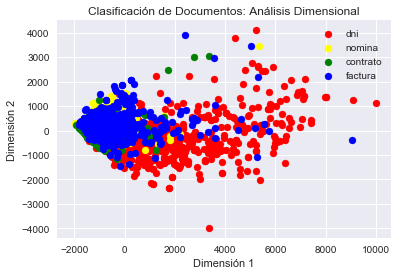

In [9]:
def get_2d_visualizaiton(data, names, num_labels, labels, image_path):
    """
    Given a specific dataset where the explicative variables are 
    stored in the variable "data" and the corresponding response variables
    in the variable "names", returns a 2d visualization of the partition of
    that data taking into account 2 principal components
    """
#     pca = RandomizedPCA(n_components=2)
    pca = PCA(n_components=2)
    X = pca.fit_transform(data)
    df = pd.DataFrame({"x": X[:, 0], "y": X[:, 1], "label":labels})
    colors = ["red", "yellow", "green", "blue"]
    colors = colors[:len(names)]
    for label, color in zip(df['label'].unique(), colors):
        mask = df['label']==label
        pl.scatter(df[mask]['x'], df[mask]['y'], c=color, label=label)
    pl.legend()
    pl.xlabel("Dimensión 1")
    pl.ylabel("Dimensión 2")
    pl.title("Clasificación de Documentos: Análisis Dimensional")
    plt.savefig(image_path+'pca_analysis.pdf')
    
get_2d_visualizaiton(data = data, names = names, 
                     num_labels = num_labels, labels = labels, image_path = image_path)

As you can see, the image of DNIs is very well clasiffied, while the other 3 documents are somehow mixed.

### 3.3 Training the classifier ###

In this section, we will train the different ML algorithms under study.

#### 3.3.1 Training the classifier: `KNN` ####

In [10]:
knn_model = KNeighborsClassifier()
knn_model.fit(train_x, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

#### 3.3.2 Training the classifier: `Logistic Regression (LR)` ####

In [11]:
lr_model = linear_model.LogisticRegression(C=1e2)

lr_model.fit(train_x, train_y)

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### 3.3.3 Training the classifier: `Decission Trees` ####

In [12]:
tree_model = tree.DecisionTreeClassifier(max_depth = 15, max_leaf_nodes=5)
tree_model.fit(train_x, train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,
            max_features=None, max_leaf_nodes=5, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

#### 3.3.4 Training the classifier: `Random Forest` ####

In [13]:
forest_model = RandomForestClassifier(max_depth=8, n_estimators=3, max_features=1)
forest_model.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features=1, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=3, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

#### 3.3.5 Training the classifier: `SVM` ####

In [14]:
svm_model = svm.SVC(gamma=0.001, C=100.)
svm_model.fit(train_x, train_y)

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## 4. Testing ##

In this section, the models obtained previousloy are tested against training and testing data.

In [15]:
results_dict = {}
columns = ["train", "test"]

index = []
results_dict["train"] = []
results_dict["test"] = []

### 4.1 Testing: `KNN` ###

In [16]:
pred_knn_test = knn_model.predict(test_x)
pred_knn_train = knn_model.predict(train_x)

In [17]:
label_numeric_dict = {"nomina":0, "dni":1, "factura":2, "contrato":3}
pd.crosstab(test_y, pred_knn_test, rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1,2,3
Actual,,,,
0,81,8,18,30
1,1,151,57,3
2,54,6,80,35
3,32,3,32,101


Let's calculate the accuracy.

In [18]:
acc_knn_test = accuracy_score(test_y, pred_knn_test)
acc_knn_train = accuracy_score(train_y, pred_knn_train)

print("Accuracy KNN test", acc_knn_test, "; Accuracy KNN train ", acc_knn_train)

index += ["knn"]
results_dict["train"] += [acc_knn_train]
results_dict["test"] += [acc_knn_test]

Accuracy KNN test 0.596820809249 ; Accuracy KNN train  0.766644693474


### 4.2 Testing: `Logistic Regression` ###

In [19]:
pred_lr_test = lr_model.predict(test_x)
pred_lr_train = lr_model.predict(train_x)

pd.crosstab(test_y, pred_lr_test, rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1,2,3
Actual,,,,
0,87,4,16,30
1,16,155,15,26
2,30,17,90,38
3,27,9,28,104


In [20]:
acc_lr_test = accuracy_score(test_y, pred_lr_test)
acc_lr_train = accuracy_score(train_y, pred_lr_train)

print("Accuracy LR test", acc_lr_test, "; Accuracy LR train ", acc_lr_train)

index += ["lr"]
results_dict["train"] += [acc_lr_train]
results_dict["test"] += [acc_lr_test]

Accuracy LR test 0.630057803468 ; Accuracy LR train  0.998681608438


### 4.3 Testing: `Decission Trees` ###

In [21]:
pred_tree_test = tree_model.predict(test_x)
pred_tree_train = tree_model.predict(train_x)

pd.crosstab(test_y, pred_tree_test, rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1,2,3
Actual,,,,
0,52,1,30,54
1,22,135,46,9
2,63,25,39,48
3,30,8,24,106


In [22]:
acc_tree_test = accuracy_score(test_y, pred_tree_test)
acc_tree_train = accuracy_score(train_y, pred_tree_train)

print("Accuracy Tree test", acc_tree_test, "; Accuracy Tree train ", acc_tree_train)

index += ["tree"]
results_dict["train"] += [acc_tree_train]
results_dict["test"] += [acc_tree_test]

Accuracy Tree test 0.479768786127 ; Accuracy Tree train  0.601845748187


### 4.4 Testing: `Random Forest` ###

In [23]:
pred_forest_test = forest_model.predict(test_x)
pred_forest_train = forest_model.predict(train_x)

pd.crosstab(test_y, pred_forest_test, rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1,2,3
Actual,,,,
0,53,3,35,46
1,5,180,17,10
2,26,33,74,42
3,17,5,32,114


In [24]:
acc_forest_test = accuracy_score(test_y, pred_forest_test)
acc_forest_train = accuracy_score(train_y, pred_forest_train)

print("Accuracy R. Forest test", acc_forest_test, "; Accuracy R. Forest train ", acc_forest_train)

index += ["forest"]
results_dict["train"] += [acc_forest_train]
results_dict["test"] += [acc_forest_test]

Accuracy R. Forest test 0.60838150289 ; Accuracy R. Forest train  0.77587343441


### 4.5 Testing: `SVM` ###

In [25]:
pred_svm_test = svm_model.predict(test_x)
pred_svm_train = svm_model.predict(train_x)

pd.crosstab(test_y, pred_svm_test, rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1,2,3
Actual,,,,
0,57,0,78,2
1,0,47,165,0
2,0,0,175,0
3,1,0,99,68


In [26]:
acc_svm_test = accuracy_score(test_y, pred_svm_test)
acc_svm_train = accuracy_score(train_y, pred_svm_train)

print("Accuracy SVM test", acc_svm_test, "; Accuracy SVM train ", acc_svm_train)

index += ["svm"]
results_dict["train"] += [acc_svm_train]
results_dict["test"] += [acc_svm_test]

Accuracy SVM test 0.501445086705 ; Accuracy SVM train  0.998681608438


## 5 Summary ##

### 5.1 Global accuracy ###

In this section, we will compare the global accuracy of all the models.

In [27]:
df_results = pd.DataFrame(data = results_dict, columns = columns, index = index)
print(df_results)

           train      test
knn     0.766645  0.596821
lr      0.998682  0.630058
tree    0.601846  0.479769
forest  0.775873  0.608382
svm     0.998682  0.501445


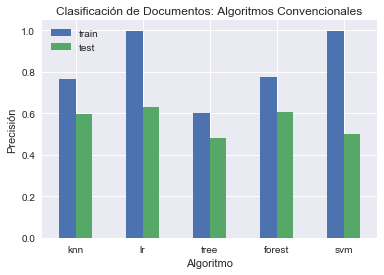

In [28]:
comparison_plot = df_results.plot(kind="bar", rot=0)
comparison_plot.set_xlabel("Algoritmo")
comparison_plot.set_ylabel("Precisión")
comparison_plot.set_title("Clasificación de Documentos: Algoritmos Convencionales")
plt.savefig(image_path+'conventional_algorithms.pdf')

As you can see, Logistic Regression and SVM suffer huge overfitting. In the other hand, Decission Trees shows the worse behaviour. KNN and Random Forest show a decent accuracy in testing without important overfitting.

### 5.2 Partial accuracy ###

Now, we will study the accuracy per type of document. To perform this study, we chose the KNN model.

In [29]:
final_result = df_results.loc[["knn"]]

The best result is reached using the `lr` model with the *augmented* data set. Let's see the cross tab of that model.

In [30]:
label_numeric_dict = {"nomina":0, "dni":1, "factura":2, "contrato":3}
crosstab_df = pd.crosstab(test_y, pred_lr_test, rownames=["Actual"], colnames=["Predicted"])
pd.crosstab(test_y, pred_lr_test, rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1,2,3
Actual,,,,
0,87,4,16,30
1,16,155,15,26
2,30,17,90,38
3,27,9,28,104


In [31]:
prediction = np.diag(crosstab_df)
actual_val = np.asarray(crosstab_df.sum(axis=1))

In [32]:
partial_pred = prediction/actual_val
print(partial_pred[0])

0.63503649635


In [33]:
total_pred = sum(prediction)/sum(actual_val)
print(total_pred)

0.630057803468


In [34]:
accu_dict = {"documento":[partial_pred[0], partial_pred[1],
                         partial_pred[2], partial_pred[3],
                         total_pred]}

accu_df = pd.DataFrame(data = accu_dict, index = ["nomina", "dni", "factura", 
                                                    "contrato", "total"],
                      columns = ["documento"])

print(accu_df)

          documento
nomina     0.635036
dni        0.731132
factura    0.514286
contrato   0.619048
total      0.630058


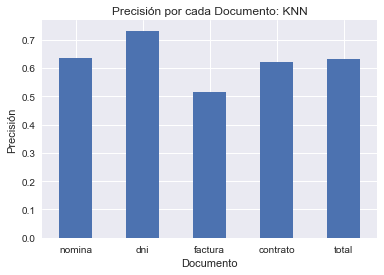

In [35]:
lr_results = accu_df.plot(kind="bar", legend=False, rot=0)
lr_results.set_xlabel("Documento")
lr_results.set_ylabel("Precisión")
lr_results.set_title("Precisión por cada Documento: KNN")
plt.savefig(image_path+'analysis_knn.pdf')

As you can see, the document beste predicted is the DNI (in aggreement with our dimension reduction analysis). On the other hand, the invoices are the document worst predicted. The global accuracy is ~0.63, which is acceptable taking into account that a random model would have an accuracy of ~0.25